In [17]:
import pandas as pd
import numpy as np
import scipy as sp
import scipy.signal as sig
import matplotlib.pyplot as plt
import peakutils as pkuts
from scipy import fftpack
from scipy.interpolate import interp1d
from matplotlib.offsetbox import AnchoredOffsetbox
import datetime as datetime
from datetime import datetime, timedelta
import os
import ctypes

In [18]:
file = '08302023_test3.txt'

In [76]:
header = 0

dat = pd.read_csv(file, header = header, dtype = str, delimiter = '|', names = ['Time','MISC','Packet','Message','RSSI'])
dat = dat[~dat.RSSI.str.contains('error')]
dat = dat[dat.MISC.str.contains('e|6')] # To keep voltage, temperature and motility data only
dat = dat.reset_index(drop=True)
dat_col = dat.Message
dat_col = dat_col.str.strip()
hexdat = dat_col.str.split(' ')

In [85]:
dat = dat.assign(Temperature = np.nan, Voltage = np.nan)

,Time,MISC,Packet,Message,RSSI,Temperature,Voltage
0,10:48:14.824,06,0001,0c f8 00 19,-11,NaN,NaN
1,10:48:18.336,06,0002,0c f8 00 19,-12,NaN,NaN
2,10:48:21.335,0e,0003,fe 34 ff 5d 41 36 ff eb ff f4 01 05,-12,NaN,NaN
3,10:48:21.379,0e,0004,ff f3 03 49 41 3f ff ea ff f1 00 00,-12,NaN,NaN
4,10:48:21.379,0e,0005,0b 4d 04 76 41 d7 ff ea ff e9 fe 9c,-12,NaN,NaN
...,...,...,...,...,...,...,...
8364,10:52:59.663,06,8365,0c f8 00 19,-11,NaN,NaN
8365,10:53:03.145,06,8366,0c f8 00 19,-11,NaN,NaN
8366,10:53:06.656,06,8367,0c f8 00 19,-11,NaN,NaN
8367,10:53:10.167,06,8368,0c f8 00 19,-12,NaN,NaN


In [86]:
for k, ele in enumerate(hexdat): # k: count; ele: item
        if len(ele) == 12: # Only select those that have the correct length
            vlist=[]
            for i in range(0, 6):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i <= 2:
                    vlist.append(round(float(convert_value)*0.061/1000, 2))
                else:
                    vlist.append(round(float(convert_value)*35/1000, 2))
                    
            dat.Message[k] = vlist
            
        elif len(ele) == 4:
            dat.Message[k] = 'NaN'
            for i in range(0, 2):
                n = i*2 + 2
                value = ''.join(['0x', ele[n-2], ele[n-1]])
                hvalue = int(value, 16)
                convert_value = ctypes.c_int16(hvalue).value
                if i == 0:
                 #   vlist.append(float((convert_value/1000)))
                    dat.Voltage[k] = float((convert_value/1000))
                else:
                  #  vlist.append(float(convert_value))
                    dat.Temperature[k] = float(convert_value)
        
        else:
            #print('Line Error!'+str(k))
            #print(ele)
            vlist = [] #add empty list on error


<ipython-input-86-ea0b6fc68db0>:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.Message[k] = 'NaN'
<ipython-input-86-ea0b6fc68db0>:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.Voltage[k] = float((convert_value/1000))
<ipython-input-86-ea0b6fc68db0>:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dat.Temperature[k] = float(convert_value)
<ipython-input-86-ea0b6fc68db0>:14: SettingWithCopyWarning: 
A value is trying to b

In [87]:
dat

,Time,MISC,Packet,Message,RSSI,Temperature,Voltage
0,10:48:14.824,06,0001,NaN,-11,25.0,3.32
1,10:48:18.336,06,0002,NaN,-12,25.0,3.32
2,10:48:21.335,0e,0003,"[-0.03, -0.01, 1.02, -0.73, -0.42, 9.13]",-12,NaN,NaN
3,10:48:21.379,0e,0004,"[-0.0, 0.05, 1.02, -0.77, -0.53, 0.0]",-12,NaN,NaN
4,10:48:21.379,0e,0005,"[0.18, 0.07, 1.03, -0.77, -0.81, -12.46]",-12,NaN,NaN
...,...,...,...,...,...,...,...
8364,10:52:59.663,06,8365,NaN,-11,25.0,3.32
8365,10:53:03.145,06,8366,NaN,-11,25.0,3.32
8366,10:53:06.656,06,8367,NaN,-11,25.0,3.32
8367,10:53:10.167,06,8368,NaN,-12,25.0,3.32


In [88]:
 # get only the filename from the file path
_, filename = os.path.split(file)
date = filename.split('_')[0]
date = datetime.strptime(date, '%m%d%Y') #which takes in "MMDDYYYY" like only US people write date order
 # Convert "realtime" to datetime, adding the date
dat["Time"] =  dat["Time"].str.strip()
dat["Time"] = pd.to_datetime(dat["Time"], format='%H:%M:%S.%f')
dat["Time"] = dat["Time"].apply(lambda t: datetime.combine(date, t.time()))
# Check for date rollover and increment the date when necessary
dat["Time"] = dat["Time"].mask(dat["Time"].diff().dt.total_seconds() < 0, 
                                           dat["Time"] + timedelta(days=1))

In [89]:
dat[['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = np.nan

'NaN'

In [90]:
dat.loc[dat.Message != 'NaN', ['XL_X', 'XL_Y', 'XL_Z', 'G_X', 'G_Y', 'G_Z']] = dat[dat.Message != 'NaN'].Message.tolist()

In [156]:
dat["Packet"] = dat["Packet"].astype(int)
dat

,Time,MISC,Packet,Message,RSSI,Temperature,Voltage,XL_X,XL_Y,XL_Z,G_X,G_Y,G_Z
0,2023-08-30 10:48:14.824,06,1,NaN,-11,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-08-30 10:48:18.336,06,2,NaN,-12,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-08-30 10:48:21.335,0e,3,"[-0.03, -0.01, 1.02, -0.73, -0.42, 9.13]",-12,NaN,NaN,-0.03,-0.01,1.02,-0.73,-0.42,9.13
3,2023-08-30 10:48:21.379,0e,4,"[-0.0, 0.05, 1.02, -0.77, -0.53, 0.0]",-12,NaN,NaN,-0.0,0.05,1.02,-0.77,-0.53,0.0
4,2023-08-30 10:48:21.379,0e,5,"[0.18, 0.07, 1.03, -0.77, -0.81, -12.46]",-12,NaN,NaN,0.18,0.07,1.03,-0.77,-0.81,-12.46
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,2023-08-30 10:52:59.663,06,8365,NaN,-11,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN
8365,2023-08-30 10:53:03.145,06,8366,NaN,-11,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN
8366,2023-08-30 10:53:06.656,06,8367,NaN,-11,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN
8367,2023-08-30 10:53:10.167,06,8368,NaN,-12,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN


In [93]:
start_time = dat["Time"].iloc[0]
tarray = pd.array((dat["Time"] - start_time).dt.total_seconds())
tseries = pd.Series(tarray, name = 'Timestamp')
dat = pd.concat((dat, tseries), axis=1)
dat

,Time,MISC,Packet,Message,RSSI,Temperature,Voltage,XL_X,XL_Y,XL_Z,G_X,G_Y,G_Z,Timestamp
0,2023-08-30 10:48:14.824,06,0001,NaN,-11,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN,0.000
1,2023-08-30 10:48:18.336,06,0002,NaN,-12,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN,3.512
2,2023-08-30 10:48:21.335,0e,0003,"[-0.03, -0.01, 1.02, -0.73, -0.42, 9.13]",-12,NaN,NaN,-0.03,-0.01,1.02,-0.73,-0.42,9.13,6.511
3,2023-08-30 10:48:21.379,0e,0004,"[-0.0, 0.05, 1.02, -0.77, -0.53, 0.0]",-12,NaN,NaN,-0.00,0.05,1.02,-0.77,-0.53,0.00,6.555
4,2023-08-30 10:48:21.379,0e,0005,"[0.18, 0.07, 1.03, -0.77, -0.81, -12.46]",-12,NaN,NaN,0.18,0.07,1.03,-0.77,-0.81,-12.46,6.555
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8364,2023-08-30 10:52:59.663,06,8365,NaN,-11,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN,284.839
8365,2023-08-30 10:53:03.145,06,8366,NaN,-11,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN,288.321
8366,2023-08-30 10:53:06.656,06,8367,NaN,-11,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN,291.832
8367,2023-08-30 10:53:10.167,06,8368,NaN,-12,25.0,3.32,NaN,NaN,NaN,NaN,NaN,NaN,295.343


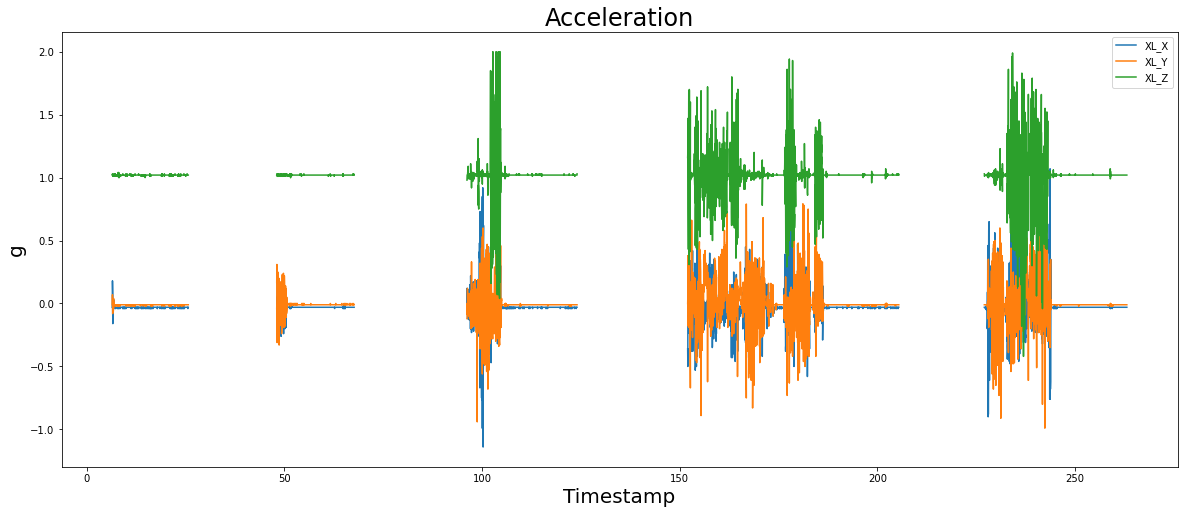

In [95]:
data_plot_XL = pd.DataFrame(dat, columns=["Timestamp", "XL_X", "XL_Y", "XL_Z"])
data_plot_XL.plot(x="Timestamp", y=["XL_X", "XL_Y", "XL_Z"], figsize=(20, 8))
plt.xlabel('Timestamp', fontsize="20")
plt.ylabel('g', fontsize="20")
plt.title("Acceleration", fontsize="24")
plt.show()

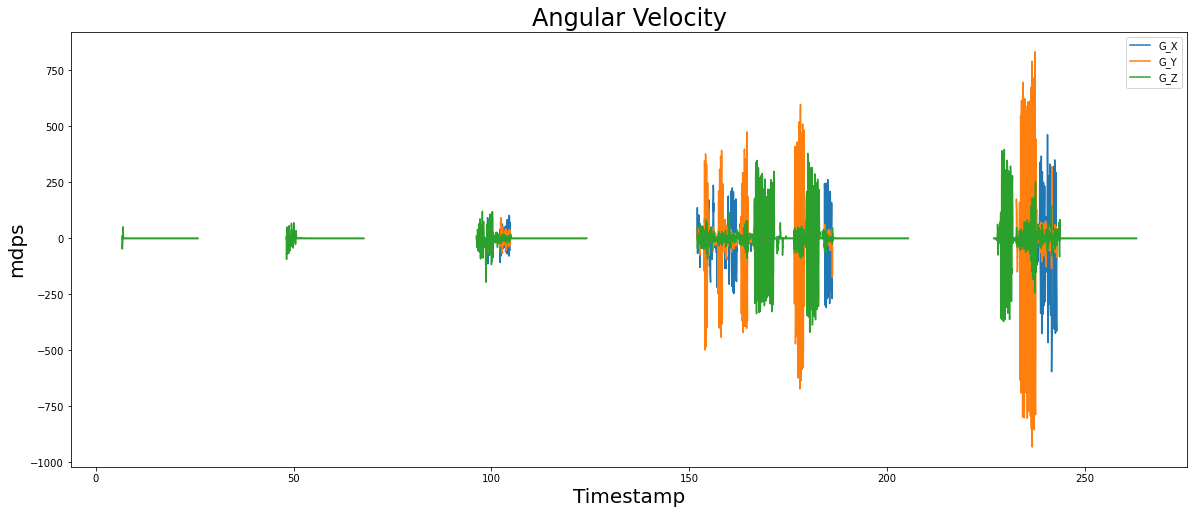

In [96]:
data_plot_G = pd.DataFrame(dat, columns=["Timestamp", "G_X", "G_Y", "G_Z"])
data_plot_G.plot(x="Timestamp", y=["G_X", "G_Y", "G_Z"], figsize=(20, 8))
plt.xlabel('Timestamp', fontsize="20")
plt.ylabel('mdps', fontsize="20")
plt.title("Angular Velocity", fontsize="24")
plt.show()